# Football Matches Data Analysis Notebook

## Introduction
This Jupyter Notebook aims to analyze the provided datasets (`X.csv` and `gamyes.csv`) to derive insights for pricing bets on goals in football matches. The notebook covers steps for data loading the datasets and training a LGBM model on them.


## Step 1: Loading the previously generated Datasets
- Import necessary libraries including pandas for data manipulation and matplotlib/seaborn for visualization.
- Load the `X.csv` and `y.csv` datasets into pandas DataFrames.


In [51]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [54]:
# Load the dataset
X = pd.read_csv('../data/X.csv', index_col="game_id")
y = pd.read_csv('../data/y.csv', index_col="game_id")

y["total"] = y["home_goals"] + y["away_goals"]
y = y["total"]
max(y)
# As it can be seen here, there are some outliers in the games with ab-normally high number of goals
# in further analysis these outliers can be eliminated to improve model's performance.

21

In [55]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model selection
Since the events sequence is very sparse, fitting a LSTM or RNN might easily result biased results towards the majority event (which is no event). So regression and LGBM seems like a good idea.


In [46]:
# Define the LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3351
[LightGBM] [Info] Number of data points in the train set: 47235, number of used features: 23
[LightGBM] [Info] Start training from score 1.478565
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Mean Squared Error: 1.6060244518037639


In [56]:
 y_pred = np.round(y_pred).astype(int) # so the predictions are integer values

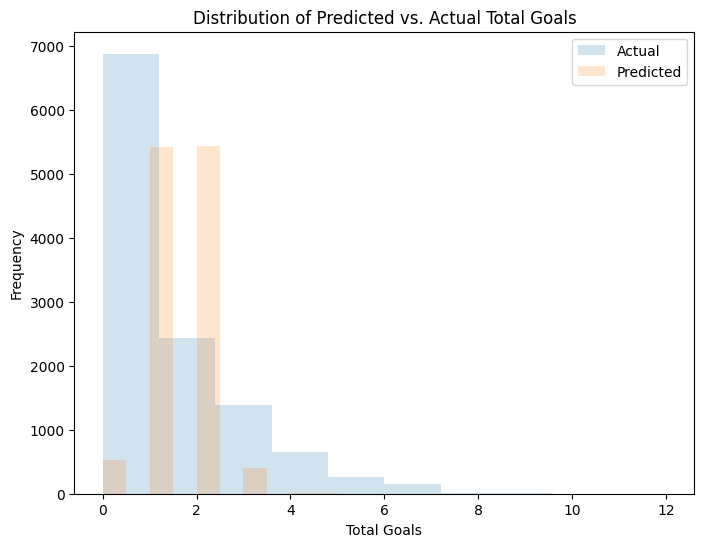

In [57]:
# Plot distributions of predicted vs. actual total goals
plt.figure(figsize=(8, 6))
plt.hist(y_test, alpha=0.2, bins = 10, label='Actual')
plt.hist(y_pred, alpha=0.2, bins=10, label='Predicted')
plt.title('Distribution of Predicted vs. Actual Total Goals')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

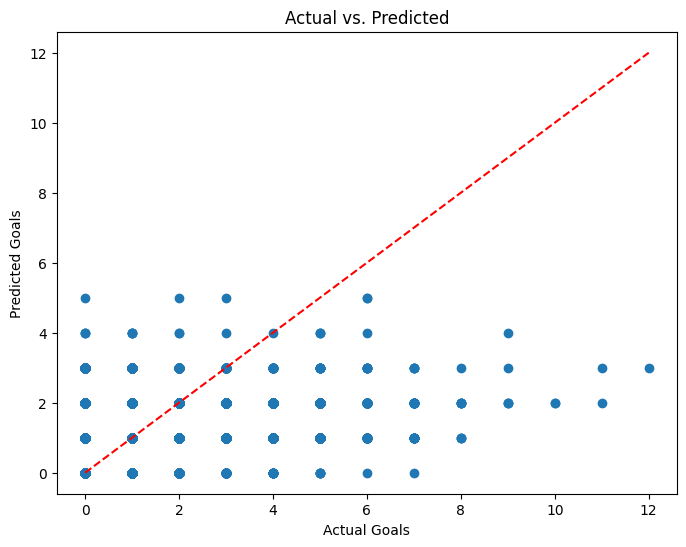

In [58]:
# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test.values.min(), y_pred.min()), max(y_test.values.max(), y_pred.max())],
         [min(y_test.values.min(), y_pred.min()), max(y_test.values.max(), y_pred.max())],
         linestyle='--', color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Goals')
plt.ylabel('Predicted Goals')
plt.show()

<Figure size 1000x600 with 0 Axes>

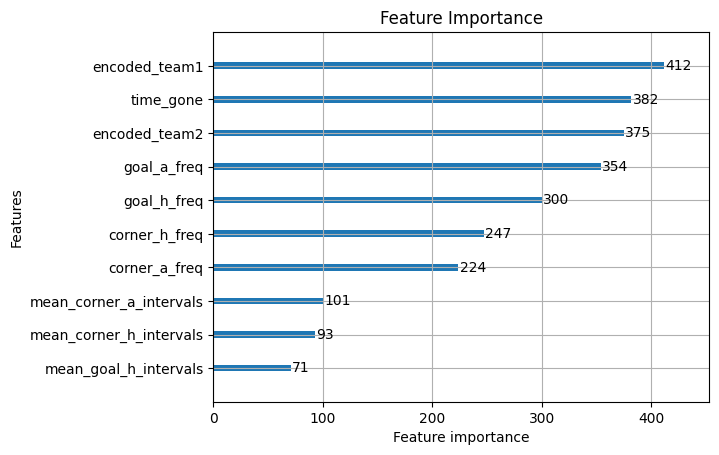

In [59]:
# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()


RESULTS: Upon examining the aforementioned analyses, it becomes evident that the model has not fully effectively captured the underlying patterns within the dataset. Based on the EDA where there were not much correlation observed between the different features, the current results makes sense. From the histograms of the predictions, it can be observed that the model is bised towards 1 and 2 goals and cannot effectively predict higher number of goals. This is because the distribution of number of goals is skewed and the median number of goals is around 1, so we expect the results to be biased towards 1 goal. To overcome this problem we can smaple more from the dataset to diversify the game scenarios. Also any number of goals above 5 seems like an outlier and in further analysis, these outliers can be removed. 

Feature importance: Overall, while team names did not have a direct numerical correlation with the number of goals scored, they seem to be serving as proxies for a range of underlying factors that influence team performance, making them valuable features in the model predictions.  

Also, goal and corner frequencies, as well as the intervals between these events, seem to be highly informative features in predicting team performance and the likelihood of scoring goals. This can be due to the fact thesef features capture the dynamics of a match, the performance levels of each team, and the likelihood of goals being scored.

FURTHER DEVELOPEMENT: i) As it can be seen here, there are some outliers in the games with ab-normally high number of goals. In further analysis these outliers can be eliminated to improve model's performance.
ii) Secondly, the features do not seem to be very informative and good representative of teams' performance during the game. To overcome this, more features can be calculated from external information about the game.
iii) thirdly, more samples from the events dataset can be randomly selected to make sure the dataset is as diversified as possible to avoid bias in the results. 
iv) Fourht, to ensure the model's robustness and generalizability, additional steps need to be done; Further hyperparameter tuning and cross-validation are essential to optimize the model's performance and validate its ability to generalize well beyond the training data. 

FEATURES: Presently, the model operates independently of input sequence, making it capable of predicting future outcomes at any point in the game. Howver, the current model is restricted to doing predictions in the first 90 mins of the game. But the model can be adapted to predict Penalties, game in the extra time,  as well as home goals or away goals individually, enhancing its versatility. 

FEATURE IMPROVWEMENTS: To augment its predictive prowess, incorporating additional information such as ball possession time, number of shoots, and other relevant features could be beneficial. By extracting more features and enriching the dataset, the model's predictive accuracy can be substantially improved. Furthermore, exploring advanced techniques like Long Short-Term Memory (LSTM) or Recurrent Neural Networks (RNN) could be advantageous, especially in scenarios where the dataset is less sparse and more comprehensive, allowing for more intricate pattern recognition and temporal dependencies to be captured.